In [207]:
# import packages
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns  
import statsmodels.api as sm

In [208]:
# Import data
path = Path('/Users/thuymle/Dropbox/SIEPR Projects/Inflation and Election Swings')
input = path / 'input'
output = path / 'output'
data = path / 'data'
election_data = (data / 'election_data')
inflation_data = (data / 'inflation_data')

### County GDP Data

In [209]:
# Import GDP Data
gdp_file = data / 'CAGDP1__ALL_AREAS_2001_2023.csv'
raw_county_gdp = pd.read_csv(gdp_file, encoding='latin-1')
raw_county_gdp.columns = raw_county_gdp.columns.str.lower()

keep = ['geoname', 'description', 'unit', '2023']
df_gdp = raw_county_gdp[keep]

df_gdp = df_gdp.map(lambda x: x.lower() if isinstance(x, str) else x)

df_gdp = df_gdp.loc[df_gdp['description'] == 'current-dollar gdp (thousands of current dollars) ']
df_gdp.drop(columns = {'description', 'unit'}, inplace = True)
df_gdp.rename(columns = {'2023': '2023_gdp', 'geoname': 'county'}, inplace = True)

In [210]:
# Edit county names to merge
# First handle multiple counties
df_gdp['county'] = df_gdp['county'].str.rstrip('*')
multi_counties = df_gdp[df_gdp['county'].str.contains(r'\+', na = False)]
multi_counties[['county_1', 'county_2', 'county_3', 'state']] = multi_counties['county'].str.extract(
    r'(?:(.*?),\s*)?(?:(.*?)(?:\s*\+\s*|\s*,\s*))?(.*?),\s*([a-z]{2})$'
)
multi_counties = pd.melt(multi_counties, id_vars = ['county', '2023_gdp'],
                                value_vars = ['county_1', 'county_2', 'county_3'], 
                                value_name = 'county_new')
multi_counties = multi_counties.dropna(subset = ['county_new']).drop(columns = ['variable']).reset_index(drop=True)
multi_counties['combo'] = 1

# Merge in
county_gdp = pd.merge(df_gdp, multi_counties, on = 'county', how = 'outer')
county_gdp['state'] = county_gdp['county'].str.split(',').str[-1]
county_gdp.loc[county_gdp['county_new'].isna(), 'county_new'] = county_gdp['county'].str.split(',').str[0]

# Handle cities
county_gdp.loc[
    county_gdp['county'].str.contains('independent city', na=False), 'county_new'
] = county_gdp['county'].str.split(',').str[0]
county_gdp['county_new'] = (
    county_gdp['county_new']
    .str.replace('(independent city)', 'city', regex=False)
    .str.strip()
)


county_gdp.rename(columns = {'county': 'county_full', '2023_gdp_x': '2023_gdp'}, inplace = True)
county_gdp['county'] = county_gdp['county_new'] + ', ' + county_gdp['state']
county_gdp = county_gdp.drop(['2023_gdp_y', 'county_new', 'state'], axis = 1)
county_gdp.dropna(subset = 'county', inplace = True)

# Remove extra spaces around commas and trim spaces
county_gdp['county'] = county_gdp['county'].str.replace(r'\s*,\s*', ', ', regex=True).str.strip()

/var/folders/vd/gxvvvrrd6lb4t053j12d3y100000gn/T/ipykernel_21152/2887060668.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_counties[['county_1', 'county_2', 'county_3', 'state']] = multi_counties['county'].str.extract(
/var/folders/vd/gxvvvrrd6lb4t053j12d3y100000gn/T/ipykernel_21152/2887060668.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_counties[['county_1', 'county_2', 'county_3', 'state']] = multi_counties['county'].str.extract(
/var/folders/vd/gxvvvrrd6lb4t053j12d3y100000gn/T/ipy

### Election Data

In [211]:
county_election_file = election_data / 'clean' / 'trump_2020_2024.csv'
df_election = pd.read_csv(county_election_file)

states_output = output / "state_abbr.csv"
states_abbr = pd.read_csv(states_output)

county_election = pd.merge(states_abbr, df_election, on = 'state', how = 'outer')
county_election['county'] = county_election['county_name'] + ', ' + county_election['state_abbr']
county_election['county'] = county_election['county'].str.replace(r'\s*,\s*', ', ', regex=True).str.strip()

county_election.drop(['state', 'state_abbr', 'county_name', 'trump %, 2020', 'trump %, 2024', 'LSAD_TRANS'], axis = 1, inplace = True)

### Merge election and GDP data

In [216]:
election_gdp = pd.merge(county_election, county_gdp, on = 'county', how = 'outer')

# Handle multiple county gdp rows
rows_keep = election_gdp[election_gdp['combo'].isna()]
rows_sum = election_gdp[election_gdp['combo'] == 1]

grouped_rows = rows_sum.groupby('county_full', as_index=False).agg({
    'totalvotes, 2020': 'sum',
    'totalvotes, 2024': 'sum',
    'trump votecount, 2020': 'sum',
    'trump votecount, 2024': 'sum',
    '2023_gdp': 'first'  # Retain the unique GDP value
})
grouped_rows['combo'] = 1
all_counties = pd.concat([grouped_rows, rows_keep]).sort_values(by='county').reset_index(drop=True)

# Generate vote swing
all_counties['trump_share_2020'] = all_counties['trump votecount, 2020'] / all_counties['totalvotes, 2020'] * 100
all_counties['trump_share_2024'] = all_counties['trump votecount, 2024'] / all_counties['totalvotes, 2024'] * 100
all_counties['vote_swing'] = all_counties['trump_share_2024'] - all_counties['trump_share_2020']

keep = ['county_full', 'vote_swing', '2023_gdp']
all_counties = all_counties[keep]
all_counties.dropna(inplace = True)
all_counties['2023_gdp'] = pd.to_numeric(all_counties['2023_gdp'], errors='coerce')


In [218]:
print(all_counties[['2023_gdp', 'vote_swing']].info())


<class 'pandas.core.frame.DataFrame'>
Index: 3064 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   2023_gdp    3064 non-null   int64  
 1   vote_swing  3064 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 71.8 KB
None


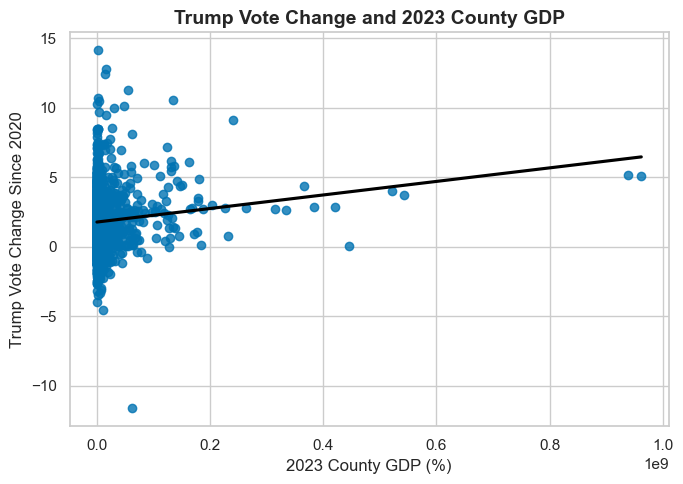

In [ ]:
sns.set_theme(style="whitegrid", palette="colorblind")

plt.figure(figsize=(7, 5))
sns.regplot(data=all_counties, x="2023_gdp", y="vote_swing", scatter=True, ci=None, line_kws={"color": "black"})

# Customize the plot
plt.title("Trump Vote Change and 2023 County GDP", fontsize=14, fontweight="bold")
plt.xlabel("2023 County GDP ($)", fontsize=12)
plt.ylabel("Trump Vote Change Since 2020 (%)", fontsize=12)
plt.tight_layout()

output_graph = output / 'gdp_election.png'
plt.savefig(output_graph, dpi=900, bbox_inches='tight')
plt.show()
